# Building Multimodal Model

In [1]:
cd ..

/notebooks/MultimodalTweetsClassification


In [2]:
#ensuring that any edits to libraries you make are reloaded here automatically
#to ensuere charts or images displayed are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

In [3]:
#importing required modules
from exp.Required_Modules_And_Packages import *
from exp.Data_Reading_And_Preprocessing import *
from exp.Required_Integration_Functionalities_For_Transformer_To_Fastai import *
from exp.Required_Functionalities_To_Handal_Multimodal_Dataset import *
from exp.Multimodal_Model_With_Intermediate_Or_EmbraceNet_Fusion import *

In [4]:
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig

In [5]:
path = Path('/notebooks/MultimodalTweetsClassification')
# path.ls()

In [6]:
path_img = path/'data_image'

In [7]:
# Uncomment the code if dataset and labels are in .tar.gz and .zip format respectively

# data = "CrisisMMD_v2.tar.gz"
# agreed_label = "crisismmd_datasplit_agreed_label.zip"
# untar_data_and_unzip_label(data,agreed_label)

In [8]:
#reading csv files and doing initial necessary processing
data_human_text_image,test_data_human_text_image = get_dataframe(*get_tsv_data_files('humanitarian_task_tsv_files'),path)

reading data and preprocessing it.....
done!!


In [9]:
print(f"shape of data: {data_human_text_image.shape}\n")
print(f"train set: {data_human_text_image['is_valid'].value_counts()[0]}")
print(f"valid set: {data_human_text_image['is_valid'].value_counts()[1]}")      
print("="*50)
print(f"shape of test data: {test_data_human_text_image.shape}\n")

shape of data: (7124, 10)

train set: 6126
valid set: 998
shape of test data: (955, 9)



In [10]:
MODEL_CLASSES = {'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig)}

In [11]:
model_type = 'xlnet'
pretrained_model_name = 'xlnet-base-cased'

In [12]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]

In [13]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [14]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)

In [15]:
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [16]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [17]:
# preprocessing and creating text databunch object for data(train and dev split) and test data(test split)
data_clas = get_text_data(data_human_text_image,path,pad_first,pad_idx,processor=transformer_processor)
test_data_clas = get_test_text_data(test_data_human_text_image,path,pad_first,pad_idx,processor=transformer_processor)

# making single databunch object of data and test data
data_clas.add_test(test_data_clas.train_ds)
data_clas.test_ds.y = test_data_clas.train_ds.y

In [18]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = False
# print(config)

In [19]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(pad_idx,transformer_model = transformer_model)

In [20]:
CustomAdamW = partial(AdamW, correct_bias=False)

learn_clas = Learner(data_clas, custom_transformer_model,opt_func = CustomAdamW, 
                  metrics=[accuracy,Precision1(average='macro'),
                Precision1(average='weighted'),Recall(average='macro'),Recall(average='weighted'),
               FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

In [21]:
# print(learn_clas.model)

In [22]:
# learn_clas.summary()

In [23]:
learn_clas.model.transformer = learn_clas.model.transformer.transformer
# print(learn_clas.model)

In [24]:
#creating image databunch object for data(train and dev split) and test data(test split)
data_img = get_image_data(data_human_text_image,path,224)
test_data_img = get_test_image_data(test_data_human_text_image,path,224)

# making single databunch object of data and test data
data_img.add_test(test_data_img.x)
data_img.test_ds.y = test_data_img.y

In [25]:
# creating a learner object with image model to use it for concatenation 
arch = models.resnet50
learn_img = cnn_learner(data_img, arch, metrics=[accuracy,Precision(average='macro'),Precision(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

In [26]:
# learn_img.model

In [27]:
learn_img.model[-1] = learn_img.model[-1][:-3]
# learn_img.model

In [28]:
#creating dataset object of ConcatDataset Class
train_ds = ConcatDataset(data_img.train_ds, data_clas.train_ds.x, data_clas.train_ds.y)
valid_ds = ConcatDataset(data_img.valid_ds, data_clas.valid_ds.x, data_clas.valid_ds.y)
test_ds = ConcatDataset(data_img.test_ds, data_clas.test_ds.x,data_clas.test_ds.y)

# creating data sampler object
bs = 16
train_sampler = SortishSampler(data_clas.train_ds.x, key=lambda t: len(data_clas.train_ds[t][0].data), bs=bs//2)
valid_sampler = SortSampler(data_clas.valid_ds.x, key=lambda t: len(data_clas.valid_ds[t][0].data))
test_sampler = SortSampler(data_clas.test_ds.x, key=lambda t: len(data_clas.test_ds[t][0].data))

In [29]:
# creating dataloader object for databuch
train_dl = DataLoader(train_ds, bs, sampler=train_sampler)
valid_dl = DataLoader(valid_ds, bs, sampler=valid_sampler)
test_dl = DataLoader(test_ds, bs, sampler=test_sampler)

In [30]:
#creating combined image+text databuch object to use it in learner for training 
data = DataBunch(train_dl=train_dl,valid_dl=valid_dl,test_dl=test_dl, device=defaults.device, 
                 collate_fn=my_collate, path=path)

In [31]:
(x1,x2),y = next(iter(data.test_dl))
print(f'Shape image batch : {(x1.shape)}')
print(f'Shape text batch: {x2.shape}')
print(f'Shape dependent var: {y.shape}')

Shape image batch : torch.Size([16, 3, 224, 224])
Shape text batch: torch.Size([16, 71])
Shape dependent var: torch.Size([16])


In [32]:
lin_layers = [512+768, 5]
ps = 0.1
model = IntermediateConcatModel(learn_img.model, learn_clas.model, lin_layers, ps,with_transformer=True)

In [33]:
#making layer groupes and creating learner object for training
loss_func = nn.CrossEntropyLoss()

layer_groups = [nn.Sequential(*(flatten_model(learn_clas.model.transformer.word_embedding)+
                                flatten_model(learn_clas.model.transformer.layer[0])+
                                flatten_model(learn_clas.model.transformer.layer[1])+
                                flatten_model(learn_clas.model.transformer.layer[2])+
                                flatten_model(learn_img.layer_groups[0]))),
                
                nn.Sequential(*(flatten_model(learn_clas.model.transformer.layer[3])+
                                flatten_model(learn_clas.model.transformer.layer[4])+
                                flatten_model(learn_clas.model.transformer.layer[5])+
                                flatten_model(learn_clas.model.transformer.layer[6])+
                                flatten_model(learn_img.layer_groups[1]))),
                
                nn.Sequential(*(flatten_model(learn_clas.model.transformer.layer[7])+
                                flatten_model(learn_clas.model.transformer.layer[8])+
                                flatten_model(learn_clas.model.transformer.layer[9])+
                                flatten_model(learn_clas.model.transformer.layer[10])+
                                flatten_model(learn_clas.model.transformer.layer[11])+ 
                                flatten_model(learn_img.layer_groups[2]))),
               nn.Sequential(*(
                   flatten_model(model.layers)))]

In [34]:
# model.eval()
learn = Learner(data, model, loss_func=loss_func, metrics=[accuracy,Precision1(average='macro'),
                Precision1(average='weighted'),Recall(average='macro'),Recall(average='weighted'),
               FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)],
            callback_fns=[ShowGraph,partial(EarlyStoppingCallback, monitor='valid_loss', min_delta=0.01, patience=3),
               partial(ReduceLROnPlateauCallback,monitor='valid_loss', mode='auto', patience=0,
                       factor=0.2, min_delta=0, min_lr=0.000001)],layer_groups=layer_groups)

In [35]:
len(learn.layer_groups)

4

In [38]:
# learn.model

In [62]:
# learn.freeze()

In [66]:
# training model using discriminative fine-tunnig and gradual unfreezing
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 8.32E-04
Min loss divided by 10: 9.12E-04


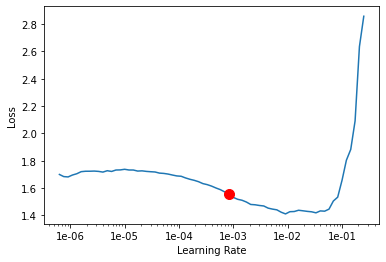

In [67]:
learn.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,1.028526,0.773075,0.733467,0.564177,0.725294,0.512911,0.733467,0.532767,0.722891,00:57
1,0.734477,0.922926,0.694389,0.601756,0.718150,0.393549,0.694389,0.416675,0.648370,00:56
2,0.585140,0.646600,0.765531,0.594448,0.758186,0.553286,0.765531,0.569820,0.759081,00:55
3,0.497389,0.657451,0.761523,0.594768,0.754735,0.545357,0.761523,0.564978,0.753303,00:56
4,0.447875,0.643159,0.769539,0.587489,0.763493,0.590196,0.769539,0.588026,0.765725,00:57


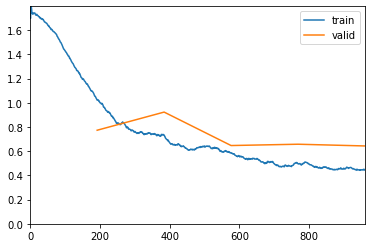

Better model found at epoch 0 with accuracy value: 0.7334669232368469.
Epoch 1: reducing lr to 0.00019009692640269474
Better model found at epoch 2 with accuracy value: 0.765531063079834.
Epoch 3: reducing lr to 3.76516692100474e-05
Better model found at epoch 4 with accuracy value: 0.7695390582084656.


In [68]:
# training the model's top layer's keeping keep other layer's in freezing mode, all the metrics shown here, have been
# evaluted on validation set
learn.fit_one_cycle(5,slice(1e-3), moms=(0.8, 0.7),wd=1e-1,
                   callbacks=[SaveModelCallback(learn,every='improvement', monitor='accuracy', name='best')])

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.892614,0.821194,0.752505,0.573292,0.748897,0.584667,0.752505,0.576921,0.749609,00:46
1,0.625385,0.738941,0.773547,0.592727,0.769809,0.594458,0.773547,0.592111,0.770001,00:46


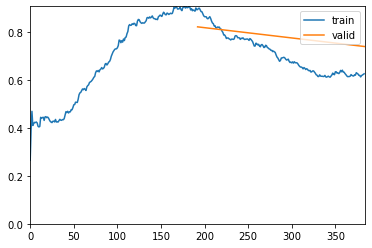

In [69]:
learn.freeze_to(-2)
learn.fit_one_cycle(2, slice(5e-3/(2.6**4), 5e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.718813,0.722295,0.758517,0.584848,0.760859,0.563499,0.758517,0.570083,0.754178,00:56
1,0.511567,0.743683,0.782565,0.631865,0.784711,0.593489,0.782565,0.608224,0.777918,00:55
2,0.173824,0.747984,0.783567,0.607738,0.781803,0.600759,0.783567,0.602887,0.780885,00:56


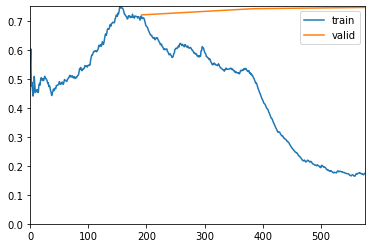

Epoch 1: reducing lr to 0.00018446409268927654


In [70]:
learn.freeze_to(-3)
learn.fit_one_cycle(3, slice(2e-3/(2.6**4), 2e-3), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


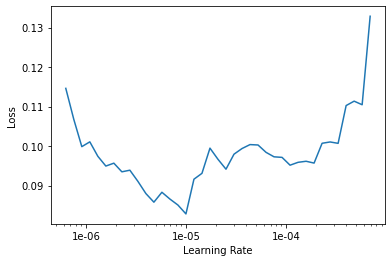

In [71]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.094890,0.755797,0.792585,0.625940,0.789909,0.598621,0.792585,0.609186,0.786779,01:06
1,0.095426,0.741370,0.786573,0.609689,0.783838,0.612147,0.786573,0.610003,0.784144,01:06


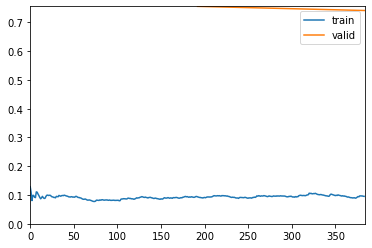

In [72]:
learn.fit_one_cycle(2, slice(5e-6/(2.6**4), 5e-6), moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,precision1,precision1,recall,recall,f_beta,f_beta,time
0,0.098456,0.730130,0.791583,0.621331,0.789370,0.607358,0.791583,0.612953,0.788466,01:05
1,0.091829,0.728732,0.790581,0.614521,0.787466,0.607825,0.790581,0.609515,0.787040,01:06
2,0.091261,0.749729,0.787575,0.610805,0.785811,0.609149,0.787575,0.608146,0.784570,01:05
3,0.097424,0.760266,0.790581,0.619363,0.785555,0.599759,0.790581,0.607365,0.785230,01:05


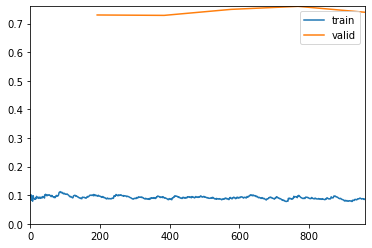

Better model found at epoch 0 with accuracy value: 0.7915831804275513.
Epoch 2: reducing lr to 6.112620219362893e-07
Epoch 4: early stopping


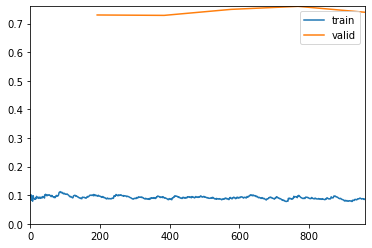

In [73]:
# training all layer's of the model and saving the best one 
learn.fit_one_cycle(5, slice(5e-6/(2.6**4), 5e-6), moms=(0.8, 0.7), wd=1e-1,
                    callbacks=[SaveModelCallback(learn,every='improvement', monitor='accuracy', name='best')])

In [74]:
# making interpretation on dev split
interp = ClassificationInterpretation.from_learner(learn)

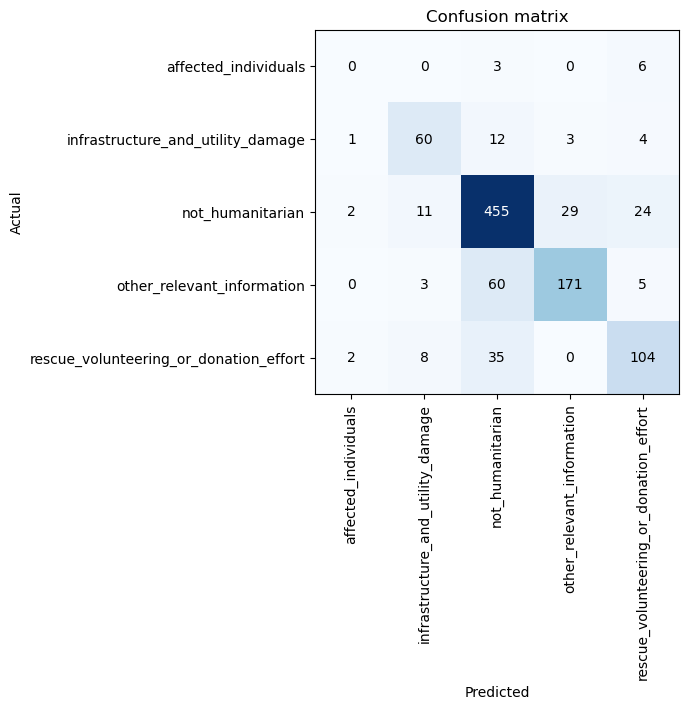

In [75]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=100)

In [76]:
learn.validate(data.valid_dl,metrics=[accuracy,Precision1(average='macro'),Precision1(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.7301298,
 tensor(0.7916),
 tensor(0.6213),
 tensor(0.7894),
 tensor(0.6074),
 tensor(0.7916),
 tensor(0.6130),
 tensor(0.7885)]

In [77]:
#making predictions on validation set to use it for classification report
valid_preds,valid_y,losses = learn.get_preds(ds_type=DatasetType.Valid,with_loss=True)
valid_y_preds = valid_preds.argmax(1)

target_names = ['affected_individuals',
 'infrastructure_and_utility_damage',
 'not_humanitarian',
 'other_relevant_information',
 'rescue_volunteering_or_donation_effort']

print(classification_report(valid_y, valid_y_preds, target_names=target_names))

                                        precision    recall  f1-score   support

                  affected_individuals       0.00      0.00      0.00         9
     infrastructure_and_utility_damage       0.73      0.75      0.74        80
                      not_humanitarian       0.81      0.87      0.84       521
            other_relevant_information       0.84      0.72      0.77       239
rescue_volunteering_or_donation_effort       0.73      0.70      0.71       149

                              accuracy                           0.79       998
                             macro avg       0.62      0.61      0.61       998
                          weighted avg       0.79      0.79      0.79       998



In [78]:
learn.validate(data.test_dl,metrics=[accuracy,Precision1(average='macro'),Precision1(average='weighted'),
                                                 Recall(average='macro'),Recall(average='weighted'),
                                                 FBeta(average='macro',beta=1.),FBeta(average='weighted',beta=1.)])

[0.6415458,
 tensor(0.8063),
 tensor(0.7450),
 tensor(0.8061),
 tensor(0.6981),
 tensor(0.8063),
 tensor(0.7184),
 tensor(0.8039)]

In [79]:
#making predictions on test set to use it for classification report
test_preds,test_y,losses = learn.get_preds(ds_type=DatasetType.Test,with_loss=True)
test_y_preds = test_preds.argmax(1)

target_names = ['affected_individuals',
 'infrastructure_and_utility_damage',
 'not_humanitarian',
 'other_relevant_information',
 'rescue_volunteering_or_donation_effort']

print(classification_report(test_y, test_y_preds, target_names=target_names))

                                        precision    recall  f1-score   support

                  affected_individuals       0.57      0.44      0.50         9
     infrastructure_and_utility_damage       0.81      0.81      0.81        81
                      not_humanitarian       0.81      0.89      0.85       504
            other_relevant_information       0.88      0.75      0.81       235
rescue_volunteering_or_donation_effort       0.64      0.59      0.61       126

                              accuracy                           0.81       955
                             macro avg       0.75      0.70      0.72       955
                          weighted avg       0.81      0.81      0.80       955

